# Constant-alpha Monte Carlo on Frozen Lake 1
Grzegorz Malisz
Student Number: 4852370
[GitHub Repository](https://github.com/grzgm/deth)

## Code
Provided code was altered to be reused for question.

In [6]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def frozen_lake(is_slippery=False, frequent_rewards=True, epsilon=0.05, alpha=0.08, gamma=0.95):
    # hyperparameters
    # epsilon = 0.05  # Exploration rate between (0-1)
    # alpha = 0.08  # Learning rate
    # gamma = 0.95  # Discount factor between (0-1)
    episodes = 4 * 2000  # Number of episodes to learn, keep this a multiple of four for nice plotting
    T = 100  # Maximum steps in an episode
    cost_of_living = -0.01  # Used when frequent_rewards = True, incentive the agent for efficiency
    # is_slippery = True

    # Choose environment
    env = gym.make("FrozenLake8x8-v1", is_slippery=is_slippery)
    # frequent_rewards = True  # When False the original environment rewards are used

    Q = np.zeros([env.observation_space.n, env.action_space.n])
    rewards_per_episode = []
    q_values_at_intervals = []  # Store Q-values at intervals

    for episode in range(episodes):
        state, prob = env.reset()
        total_reward = 0
        episode_states = []
        episode_actions = []
        episode_rewards = []

        for step in range(T):
            # Choose action based on epsilon-greedy policy
            if np.random.rand() < epsilon:
                action = np.random.choice(env.action_space.n)
            else:
                action = np.argmax(Q[state, :])

            new_state, reward, terminated, truncated, info = env.step(action)

            if frequent_rewards:
                if terminated and reward == 0:  # agent fall in the hole!
                    reward = reward - 1
                reward = reward + cost_of_living

            episode_states.append(state)
            episode_actions.append(action)
            episode_rewards.append(reward)

            total_reward += reward
            state = new_state

            if terminated:
                # if reward == 1 + cost_of_living:
                #     print(
                #         f"Episode {episode} finished after {step + 1} steps. Epsilon is {epsilon}, LR {alpha} Success!")
                break

        rewards_per_episode.append(total_reward)

        # Calculate returns and update Q-values
        G = 0
        for t in range(len(episode_states) - 1, -1, -1):
            state = episode_states[t]
            action = episode_actions[t]
            reward = episode_rewards[t]

            G = gamma * G + reward
            Q[state][action] += alpha * (G - Q[state][action])

        # Store Q-values at intervals (e.g., every 100 episodes)
        if (episode + 1) % (episodes // 4) == 0:
            q_values_at_intervals.append(np.copy(Q))  # Store a copy of Q-values

    # Plotting rewards per episode
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards_per_episode, label='Total Reward')
    plt.title('Rewards per Episode')
    plt.suptitle(f'is_slippery={is_slippery}, frequent_rewards={frequent_rewards}')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

    # Calculate moving average for a cleaner plot
    moving_average_window = 20
    moving_averages = savgol_filter(rewards_per_episode, moving_average_window, 3)
    plt.plot(moving_averages, label=f'Moving Average (Window {moving_average_window})', color='orange')

    plt.legend()

    # Plotting the heatmap of Q-values at intervals
    fig, ax = plt.subplots(1, len(q_values_at_intervals), figsize=(10, 5))

    for i, q_values in enumerate(q_values_at_intervals):
        ax[i].imshow(q_values, cmap='hot', interpolation='nearest')
        ax[i].set_title(f'Q-Values at Episode {(episodes // 4) * (i + 1)}')
        ax[i].title.set_text(f'is_slippery={is_slippery}, frequent_rewards={frequent_rewards}')
        ax[i].axis('off')  # Turn off axis
        plt.colorbar(ax[i].imshow(q_values, cmap='hot', interpolation='nearest'), ax=ax[i])
        plt.pause(0.1)  # Pause briefly to update the plot
        break

    # Display plots and pause to show the graphs
    plt.show()

## Exploration mechanism and the learning mechanism of Constant-alpha Monte Carlo

The exploration mechanism is dependent on the $0 < \epsilon \leq 1$ value, which is an exploration rate and the greedy policy $\pi$, which takes the $\underset{a}{\max} q(s, a)$. $\epsilon$ is determining the probability of making random action that is used to enhance policy. After each episode the $q(s,a)$ is updated by the formula $q(s_{t}^{m},a_{t}^{m}) \gets q(s_{t}^{m},a_{t}^{m})+\alpha(G_{t}^{m}-q(s_{t}^{m},a_{t}^{m}))$, $m$ is a sample number, $t$ is the step in the sample, which is basically $q(s_{t}^{m},a_{t}^{m})$ with added difference of the discounted return $G_{t}^{m}$ for the $s_{t}^{m}$ and $a_{t}^{m}$ with itself multiplied by constant $\alpha$. This serves as learning mechanism as it allows to estimate true value of the $q(s, a)$.

## Performance with the is_slippery=True/False

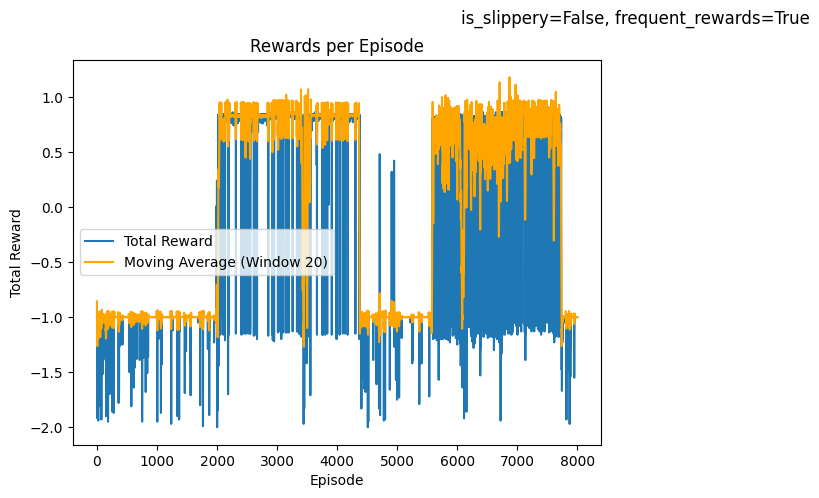

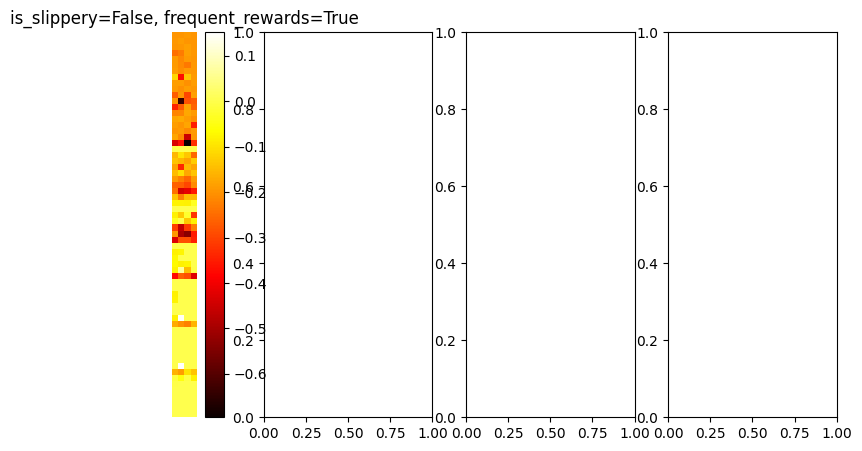

In [7]:
frozen_lake(is_slippery=False, frequent_rewards=True)

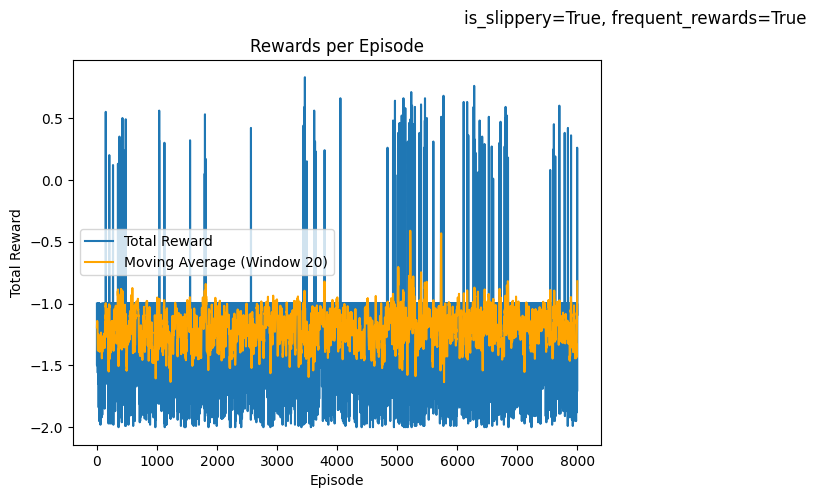

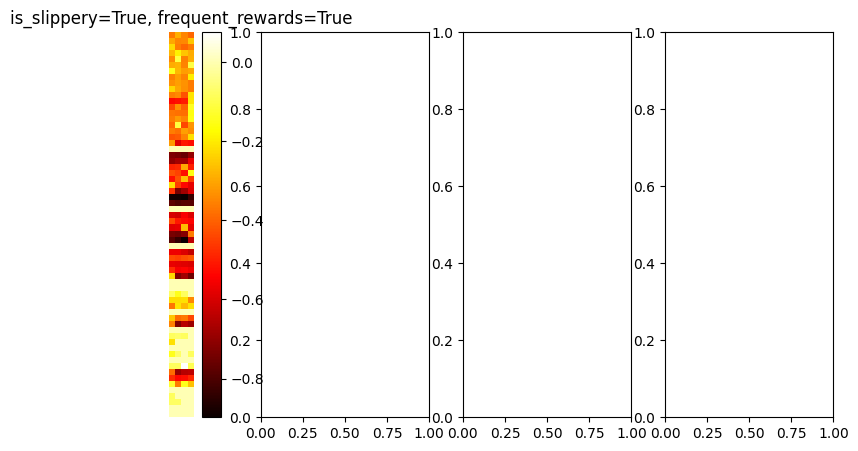

In [8]:
frozen_lake(is_slippery=True, frequent_rewards=True)

With the `is_slippery=False` agent learning process is more stable, it is transitioning from negative values to mostly positive. Changing to `is_slippery=True` makes agent receive much more negative rewards throughout whole process. It shouldn't be a surprise as the `is_slippery=True` adds the stochastic part to the learning process, where agent is no longer in the deterministic environment, and he can randomly receive `-1` reward. The `-1` reward also influences the $q(s, a)$ values, as agent is receiving more `-1` rewards then with `is_slippery=False` enabled.

## Range of values Total reward can get with is_slippery=False and frequent_rewards=True

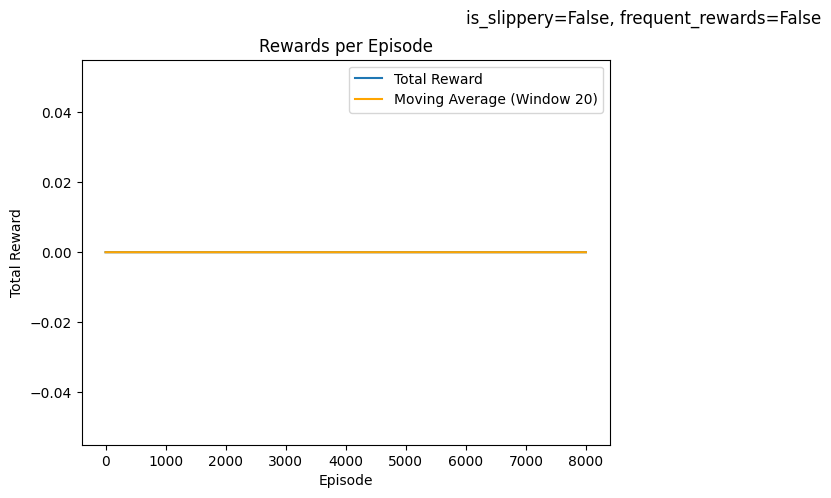

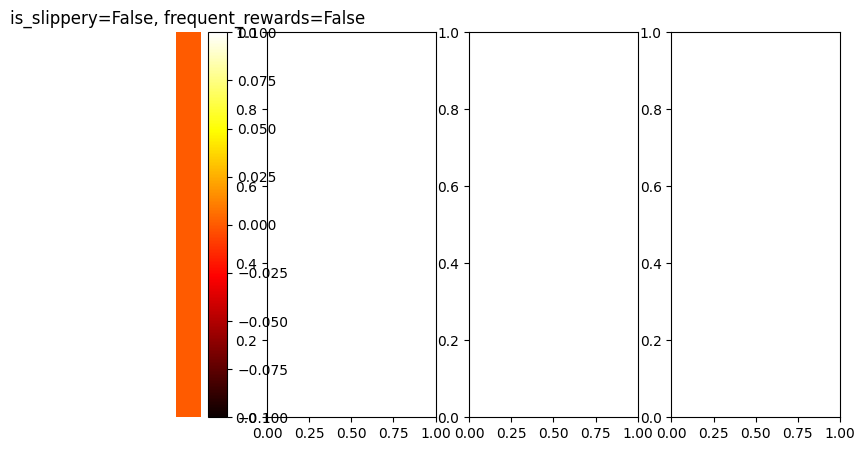

In [9]:
frozen_lake(is_slippery=False, frequent_rewards=False)

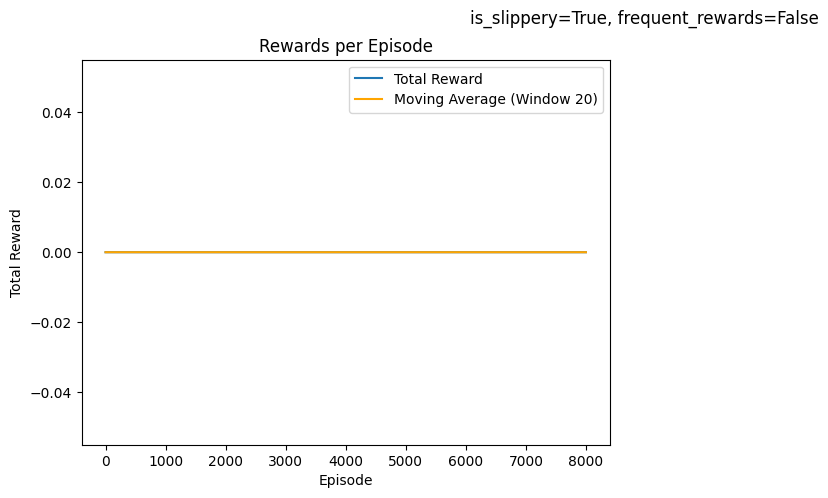

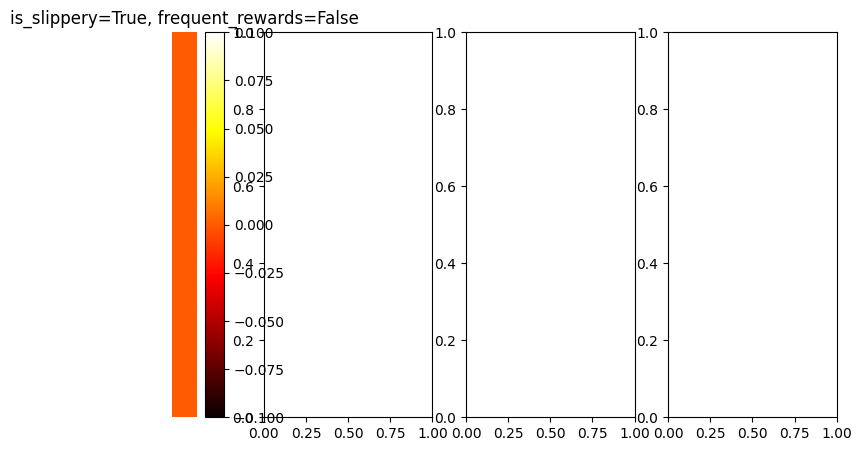

In [10]:
frozen_lake(is_slippery=True, frequent_rewards=False)

From the code provided I understand that is_slippery and frequent_rewards are tied closely, and because of this part of code:
```python
if frequent_rewards:
    if terminated and reward == 0: # agent fall in the hole!
        reward = reward - 1
    reward = reward + cost_of_living
```
if the frequent_rewards=False the is_slippery does not have any effect. Different extreme values are obtained by different values of is_slippery and frequent_rewards are between: `1` and `-2` for is_slippery=False and frequent_rewards=True and `0.5` and `-2` for is_slippery=True and frequent_rewards=True. This difference is because frequent_rewards=True enables also cost of living, that lowers final reward.

## Main Question
All the tests below, have the `is_slippery=False` and `frequent_rewards=True`, which corresponds to the agent receiving small penalty for every step, that makes him find short routes to the terminal state with positive reward in the deterministic environment.

### $\epsilon$ $\alpha$ $\gamma$

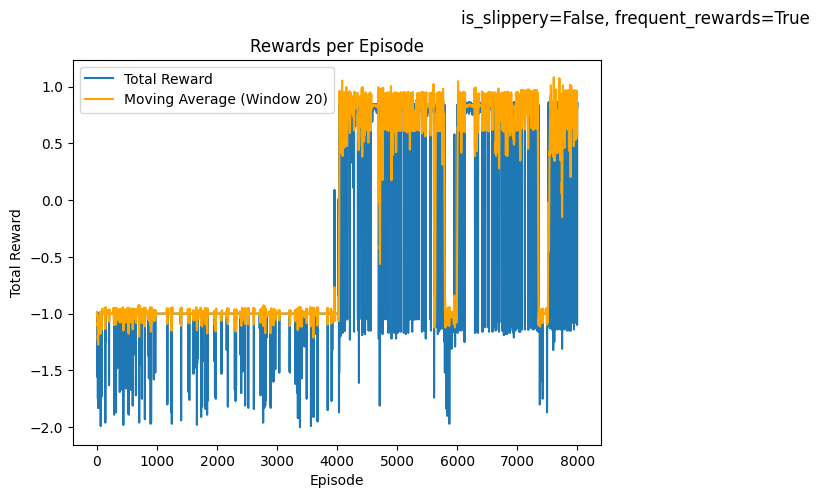

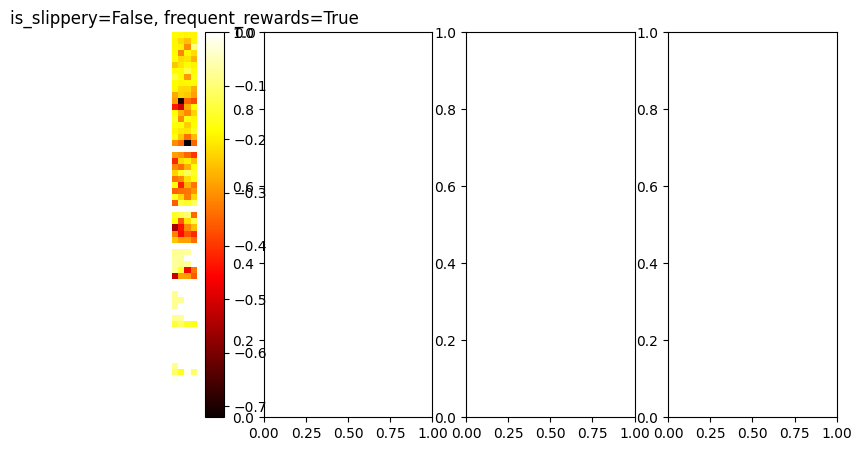

In [15]:
frozen_lake(epsilon=0.05, alpha=0.08, gamma=0.95)

With these hyperparameters agent seem to start learning and then from time to time makes mistakes. This is result of the $\alpha$ that with value as high as `0.08` is giving proper results with some fluctuation and the $\epsilon$ that makes agent try different actions with $5%$ chance. Both $\alpha$ fluctuations and $\epsilon$ exploration can explain differences in later episodes.

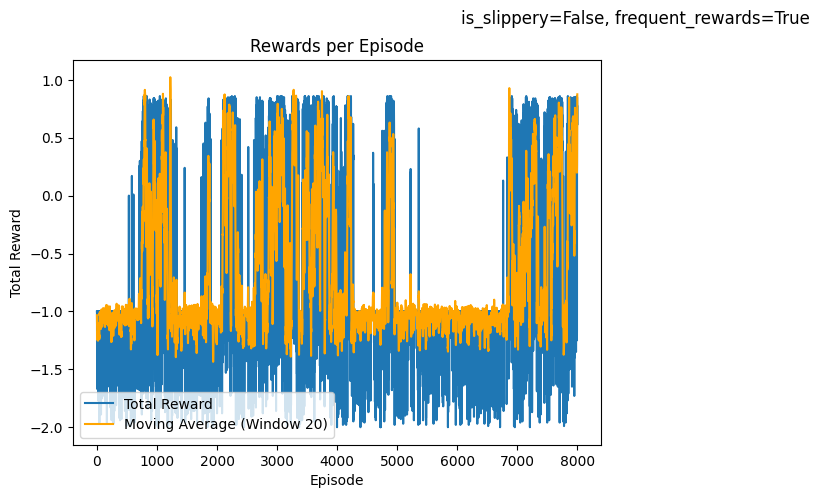

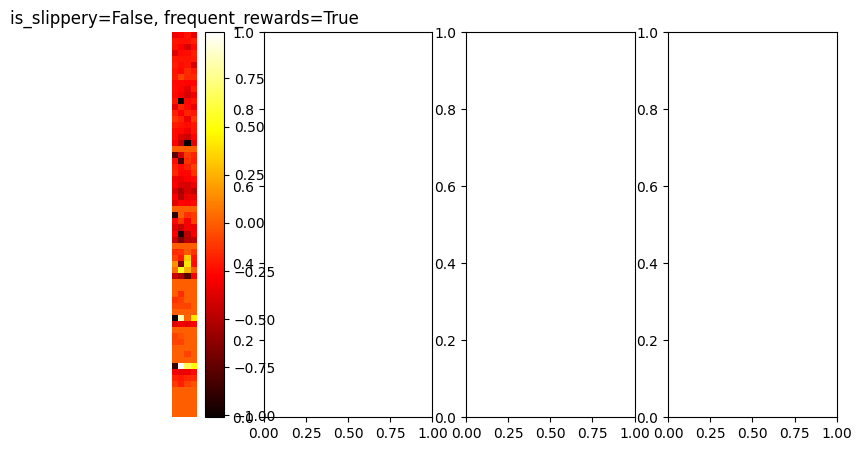

In [19]:
frozen_lake(epsilon=0.3, alpha=0.08, gamma=0.95)

$\epsilon$ with value `0.3` makes agent take random action really often which is the reason for the reward fluctuation during whole learning process. Some noise is also provided by the $\alpha$, but with these hyperparameters the $\epsilon$ is mainly responsible for this.

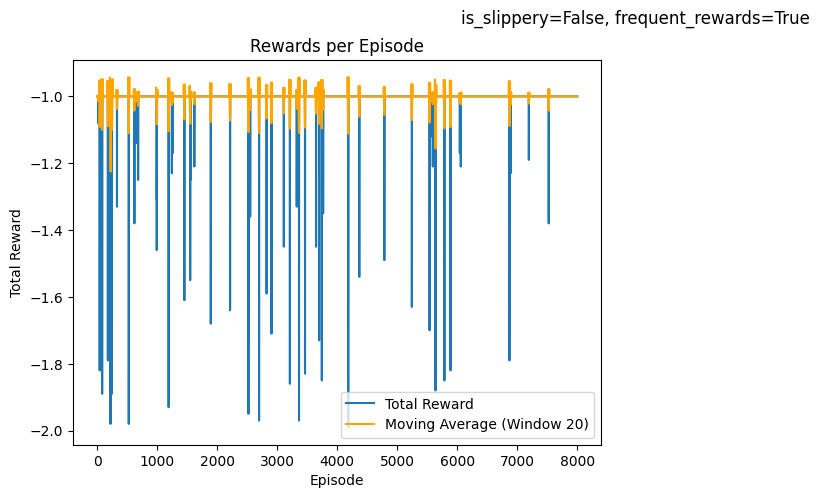

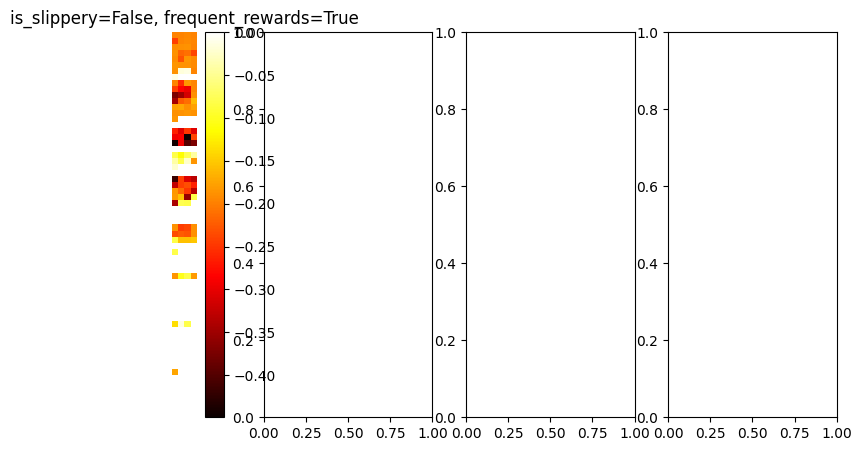

In [21]:
frozen_lake(epsilon=0.01, alpha=0.08, gamma=0.95)

$\epsilon$ with value `0.01` makes agent mostly follow the greedy policy with $q(s, a)$ being filled with default values. This stops agent from learning in the reasonable time and would require many episodes to provide useful behaviour.

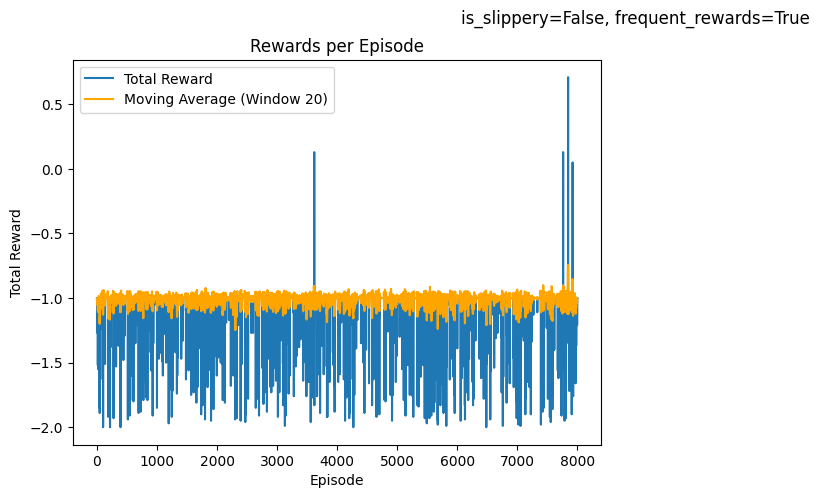

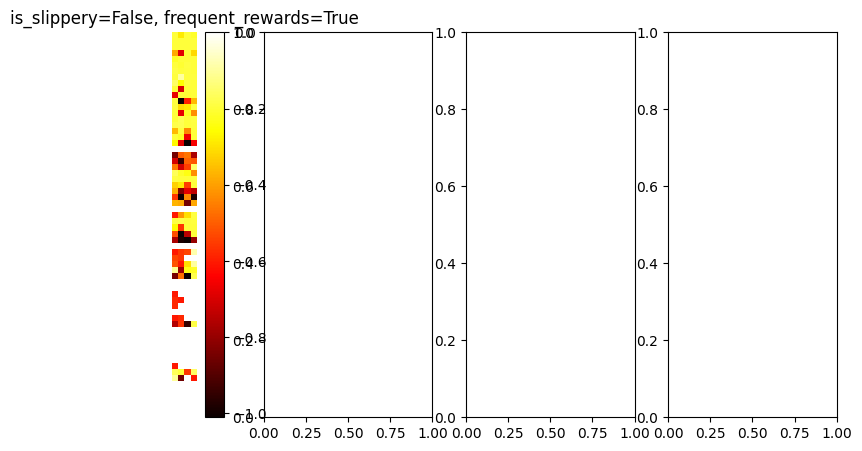

In [29]:
frozen_lake(epsilon=0.05, alpha=0.6, gamma=0.95)

$\alpha = 0,06$ makes $q(s,a)$ really prone to fluctuations, as the difference between old $q(s,a)$ and new $q(s,a)$ is added with only $40%$ discount and has huge influence. This results in $q(s,a)$ changing really significantly with every episode and one time reward has huge influence on the $q(s,a)$, with corresponds in quick estimation of true $q(s,a)$, but very noisy one.

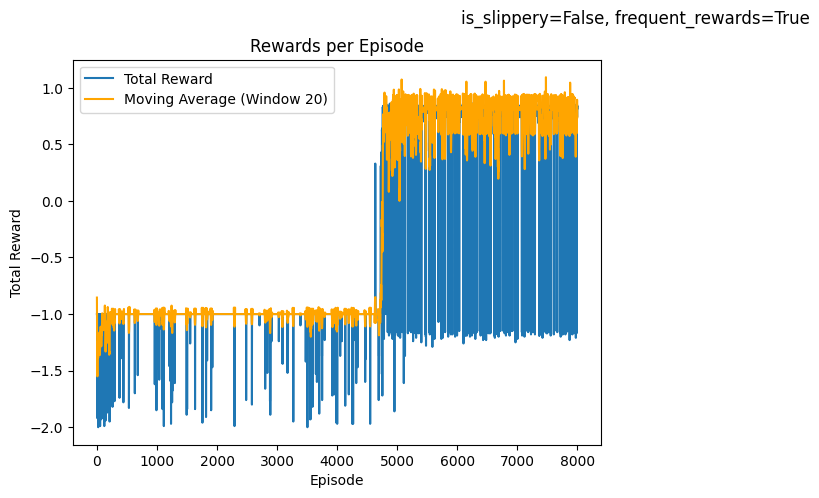

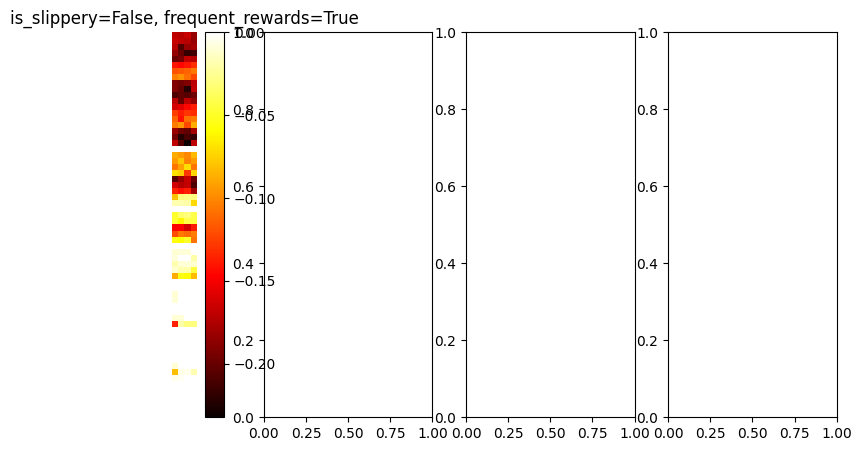

In [27]:
frozen_lake(epsilon=0.05, alpha=0.01, gamma=0.95)

$\alpha = 0,01$ makes each difference between old $q(s,a)$ and new $q(s,a)$ less significant. This results in $q(s,a)$ slowly converging to optimal values, but with much less noise.

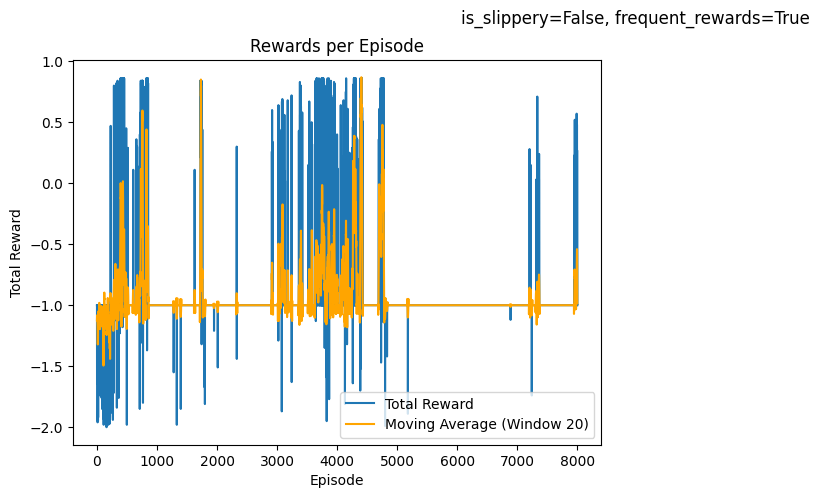

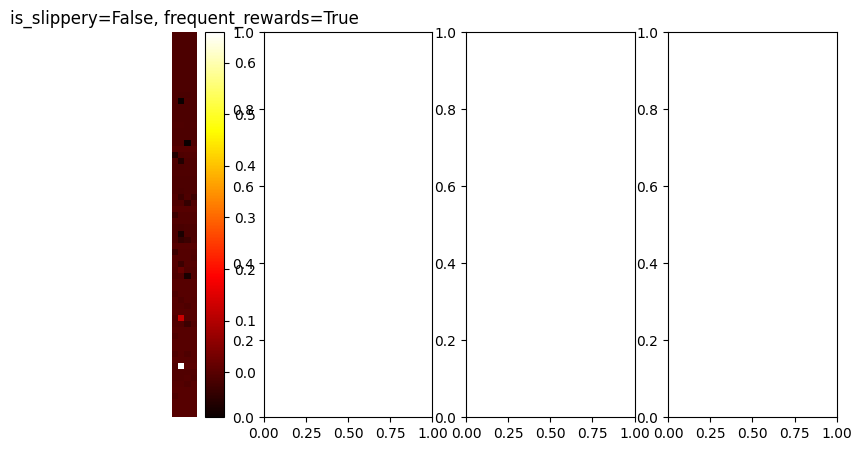

In [30]:
frozen_lake(epsilon=0.05, alpha=0.01, gamma=0.2)

$\gamma$ with low value of $20%$ makes agent focus on the short term reward, as every future reward will be discounted by the $\gamma$ raised to an increasing power ($0,2; 0,04; 0,008$). High value of $\gamma$ makes agent try to maximise future reward more, by taking higher values of the discounted future rewards.

### Best configuration

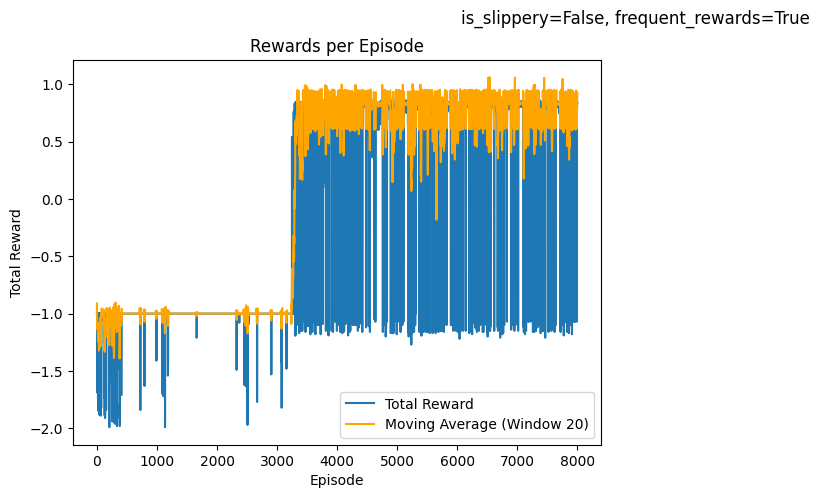

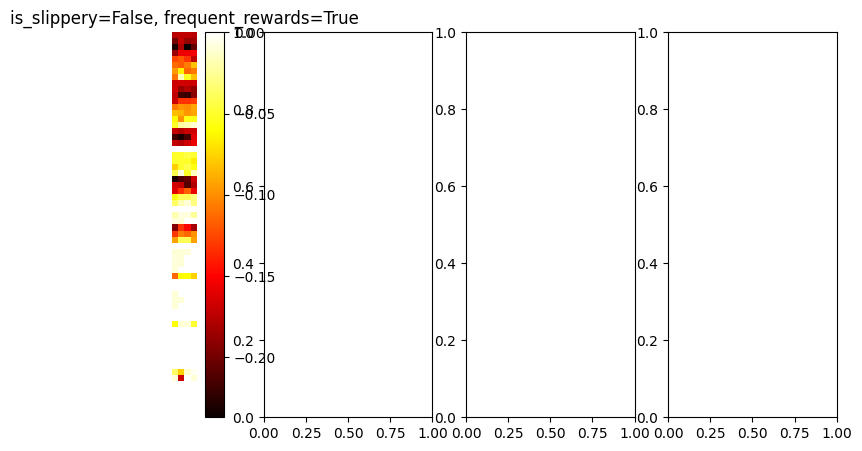

In [17]:
frozen_lake(epsilon=0.05, alpha=0.01, gamma=0.95)

This configuration seems to work the best for me, as it uses reasonable $\epsilon$ that allows agent to explore, but makes him visit profitable routes. $\alpha$ with value `0.01` makes agent slowly and what is more important steadily find the correct values of $q(s, a)$. $\gamma$ of `0.95` allows agent to focus on future rewards, which nicely accompany learning process.

## Extra challange

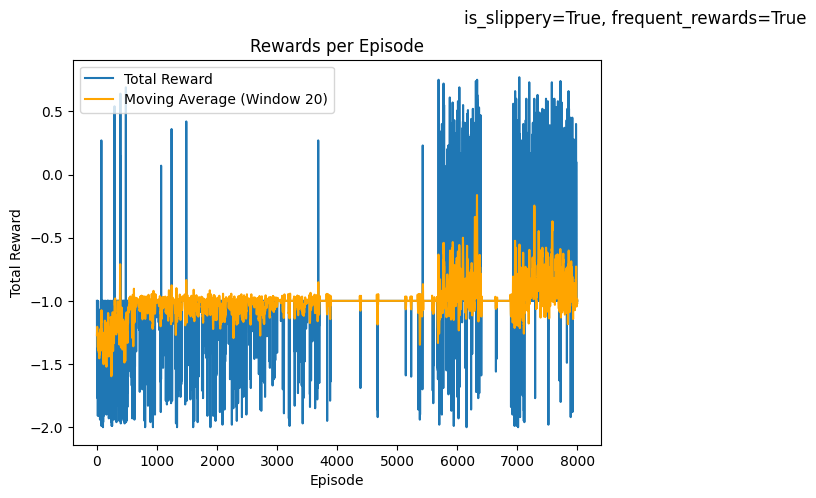

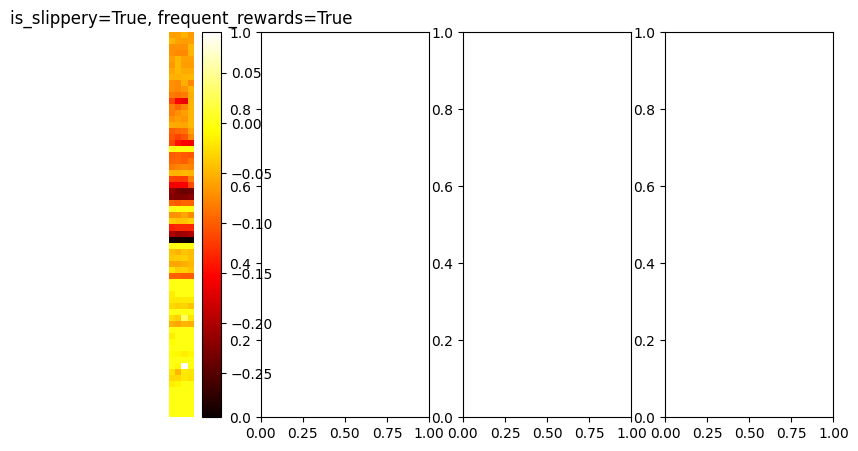

In [39]:
frozen_lake(is_slippery=True, frequent_rewards=True, epsilon=0.01, alpha=0.01, gamma=0.8)

`frozen_lake(is_slippery=True, frequent_rewards=True, epsilon=0.01, alpha=0.01, gamma=0.8)` seems to be doing quite well.

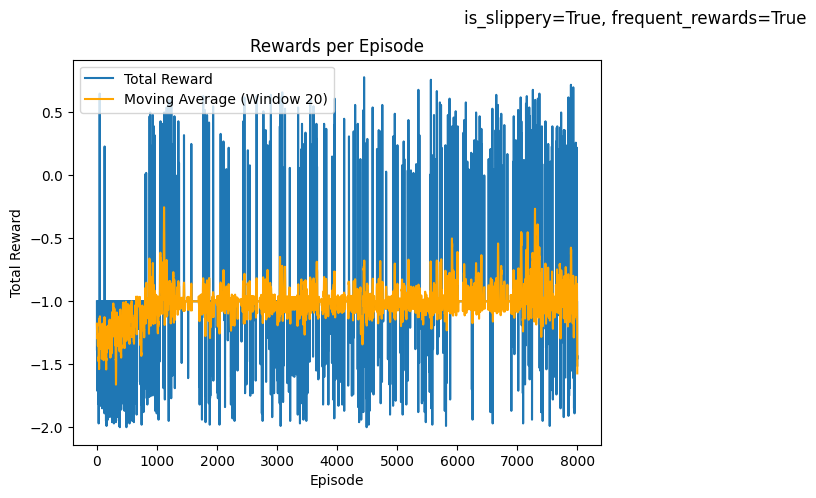

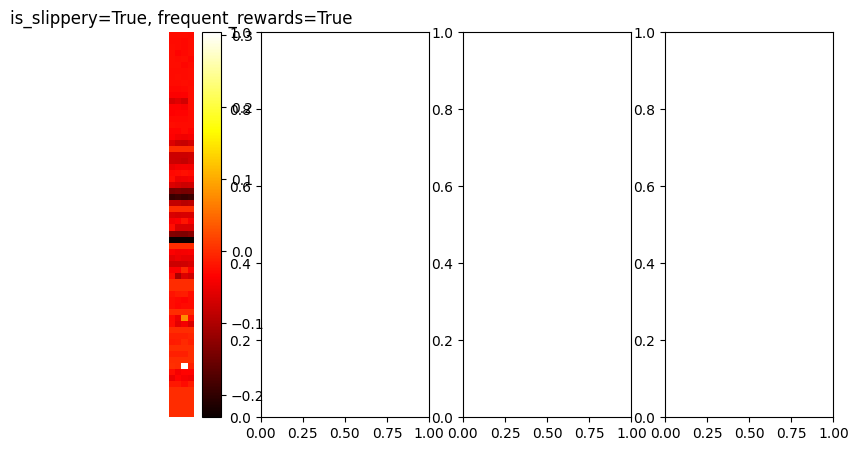

In [34]:
frozen_lake(is_slippery=True, frequent_rewards=True, epsilon=0.01, alpha=0.01, gamma=0.6)

`frozen_lake(is_slippery=True, frequent_rewards=True, epsilon=0.01, alpha=0.01, gamma=0.6)` and also these hyperparametes are working somewhat good.

I wasn't able to make the agent learn, and achieve the rewards close to 1, but still his progress looks steady enough. I think it is due to low $\epsilon$ which makes agent inspect high reward choices more, $\alpha$ that takes the changes of reward with less influence, and it should help with stochastic environment from the `is_slippery=True`. $\gamma$ at the end makes agent focus on short term rewards, which might also help with the noise from `is_slippery=True`. The best configuration with `is_slippery=False` can be found earlier.